# Training of models to segment poplar necrosis from other tissues, using `CubeML`

## Load libraries and get ready...

In [1]:
cd ../

/media/gmobot/data/NSF_GWAS/notebooks/Broadband/cubeml


In [2]:
import sys
import torch
import pickle

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("Pickle version:", pickle.format_version)


Python version: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
PyTorch version: 2.0.0+cu117
Pickle version: 4.0


In [3]:
import pickle
import spectral
#spectral.settings.envi_support_nonlowercase_params = True
from cubeml import TrainingData
from cubeml import CubeSchool
from cubeml import CubeLearner
from cubeml.model_evaluation import presentable_table
from cubeml.model_evaluation import generate_falsecolor_images
from cubeml.model_evaluation import compare_inferences
from cubeml.model_evaluation import match_files
import os

2024-09-30 18:02:25.306309: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 18:02:25.598288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 18:02:26.662076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Specify paths to hyperspectral images, and training label outputs from LabelStudio

In [4]:
#change this each model run

# Hyperspectral 
hypercube_dir = "../poplar_regen_halogen_ZTEST4/"

# LabelStudio - two types of data need to be exported
json_file = '../poplar_regen_halogen_ZTEST4/LabelStudio_outputs/project-9-at-2024-09-30-22-15-43747c63.json'
png_directory = "../poplar_regen_halogen_ZTEST4/LabelStudio_outputs/"

In [5]:
# Where should various outputs be saved?
falsecolor_dir = "output/falsecolor"
learner_plot_dir = "output/learner_plots"
panel_image_dir = "output/panel_images"

In [6]:
[os.makedirs(dir, exist_ok=True) for dir in [falsecolor_dir, learner_plot_dir, panel_image_dir]]

[None, None, None]

## Prepare models

### Combine classes

This step is optional. Here, we have labels for stem, callus, shoot and necrosis (in addition to background). In this specific case, we want to use this data to produce a model that is very good at distinguishing necrotic tissues from all others, at earlier timepoints where callus and shoot have not yet formed. Thus, we will combine our callus, shoot and stem classes into a "non-necrotic" class as specified below

In [7]:
######label_replacements = { }
    


### Build `TrainingData`

#### Generate

In [8]:
training_data = TrainingData(
    json_file = json_file,
    img_directory = hypercube_dir,
    png_directory = png_directory,
    normalize_features = True,
    ####label_remapping = label_replacements # Include this line only when we have `label_replacements` such as our necrosis example
    #use_hdf5 = True, # Are we reloading `TrainingData` already make and saved into an hdf5? (usually not)
    #hdf5_path = "poplar_training_a2-v7.hdf5" # If so, where is it?
)


Number of PNG files found: 60
Processing row 0/20 of the dataframe...
load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Shape of hypercube for task 170: (1567, 1419, 469)
Shape of label image for task 170: (1419, 1567)
Number of selected pixels for label Background: 1129050
Processing row 1/20 of the dataframe...
load mode isload_full_then_crop
Shape of hypercube for task 171: (1570, 1419, 469)
Shape of label image for task 171: (1419, 1570)
Number of selected pixels for label Background: 680792
Shape of label image for task 171: (1419, 1570)
Number of selected pixels for label Callus: 7933
Shape of label image for task 171: (1419, 1570)
Number of selected pixels for label Explant: 3932
Shape of label image for task 171: (1419, 1570)
Number of selected pixels for label Shoot: 1241
Processing row 2/20 of the dataframe...
load mode isload_full_then_crop
Shape of hypercube for task 172: (1567, 1419, 469)
Shape of label image for task 172: (1419, 1567)
Number of selected pixels for label Background: 986395
Shape of label image for task 172: (1419, 1567)
Number of selected pixels for label Callus: 18962
Shap

In [9]:
filename = "output/ZTEST4_training_a10.pkl"           #change this each model run
pickle.dump(training_data, open(filename, 'wb'))

#### Take stratified sample and save out

In [10]:
training_data.stratified_sample()

Debugging stratified_sample
Counts before stratified sampling:
0    20383832
1      351108
3      130698
2       32741
Name: Label, dtype: int64
Smallest sample size before sampling: 32741


In [11]:
filename = "output/ZTEST4_training_a10.pkl"                  #change this each model run
pickle.dump(training_data, open(filename, 'wb'))

#### If we want to reload `TrainingData` already created and saved out in `pkl` format...

In [12]:
# import pickle

# # Given filename
# filename = "output/euc_a1-v5.pkl"

# # Load the object from the file
# with open(filename, 'rb') as f:
#     training_data = pickle.load(f)


In [13]:
# import pandas as pd

# # Creating the sample data with desired string labels
# data = {
#     "Label": ["Background", "Callus", "Necrotic", "Explant", "Shoot"],
#     "Integer": [0, 1, 2, 3, 4]
# }
# labels_key_df = pd.DataFrame(data)

# # Displaying the DataFrame
# labels_key_df


In [14]:
# training_data.labels_key_df = labels_key_df

## Specify colors for specific classes

In [15]:
training_data.labels_key_df

,Label,Integer
0,background,0
1,callus,1
2,explant,2
3,shoot,3


In [19]:
#change this each model run

colors = ['#000000', '#10EF9D', '#1035EF', '#E010EF']  # User-provided color list

#### Save out key in a format we can later reload into GMOlabeler

In [20]:
labels_key_df = training_data.labels_key_df

In [21]:
# Create DataFrame
labels_and_colors = labels_key_df.copy()

labels_and_colors.rename(columns={"Label": "Tissue"}, inplace=True)

# Add Colors column
labels_and_colors['hex_code'] = colors

In [22]:
labels_and_colors

,Tissue,Integer,hex_code
0,background,0,#000000
1,callus,1,#10EF9D
2,explant,2,#1035EF
3,shoot,3,#E010EF


In [23]:
labels_and_colors = labels_and_colors[['Tissue', 'hex_code', 'Integer']]

In [24]:
labels_and_colors

,Tissue,hex_code,Integer
0,background,#000000,0
1,callus,#10EF9D,1
2,explant,#1035EF,2
3,shoot,#E010EF,3


In [25]:
key_filename = "output/ZTEST4_training_a10.key.csv"                     #change this each model run
labels_and_colors.to_csv(key_filename)

#### `plot_spectra` for `TrainingData`

Let's inspect our data to make sure we have clearly visible differences in spectra between our classes.

/tmp/ipykernel_10158/2139949131.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


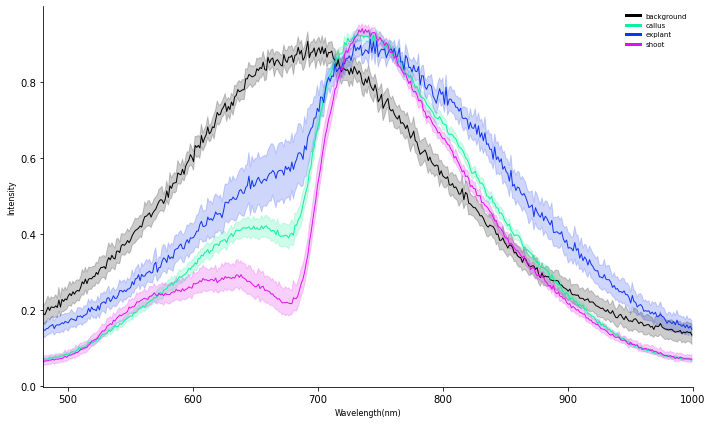

In [26]:
fig = training_data.plot_spectra(colors, sampling_fraction = 0.001)
spectra_filename = png_directory.replace('/', '_spectra.png')
fig.savefig("output/" + spectra_filename)
fig.show()

### Build `CubeLearner` objects inside `CubeSchool`

In [27]:
#pip install pympler

In [28]:
from pympler.asizeof import asizeof

print(asizeof(training_data), "bytes")

247076280 bytes


In [29]:
import sys
sys.getsizeof(training_data)

48

See current documentation for full list of models currently supported. Thus far, the ones that tend to perform best are Linear Discriminant Analysis (LDA), Gradient Boosting Classifiers (GBC), Logistic Regression (LR) and Transformer-based Neural Networks (TNN). With the code below we will produce a `CubeSchool` object that contains four `CubeLearner` objects, one for each of these four model types.

Predicted train labels shape: (104771,)
Predicted test labels shape: (26193,)
Transformed train data shape: (104771, 3)
Transformed test data shape: (26193, 3)
Shape of labels_train: (104771,)
Type of labels_train: <class 'numpy.ndarray'>
Unique values in labels_train: [0 1 2 3]
Shape of results_train: (104771,)
Type of results_train: <class 'numpy.ndarray'>
Unique values in results_train: [0 1 2 3]
Train data confusion matrices for each class: {0: array([25852,    21,   318,     2]), 1: array([    5, 24897,   243,  1048]), 2: array([  509,  3889, 20829,   965]), 3: array([  245,  1224,    95, 24629])}
Test data confusion matrices for each class: {0: array([6449,    4,   94,    1]), 1: array([   1, 6234,   63,  250]), 2: array([ 117, 1008, 5191,  233]), 3: array([  67,  292,   34, 6155])}
Shape of predictions: (104771,)
Type of predictions: <class 'numpy.ndarray'>
Unique values in predictions: [0 1 2 3]
Shape of labels_train: (104771,)
Type of labels_train: <class 'numpy.ndarray'>
Uniq

/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Shape of predictions: (104771,)
Type of predictions: <class 'numpy.ndarray'>
Unique values in predictions: [0 1 2 3]
Shape of labels_train: (104771,)
Type of labels_train: <class 'numpy.ndarray'>
Unique values in labels_train: [0 1 2 3]
Shape of results_train: (104771,)
Type of results_train: <class 'numpy.ndarray'>
Unique values in results_train: [0 1 2 3]
Train data confusion matrices for each class: {0: array([25791,    93,   254,    55]), 1: array([    1, 24144,   423,  1625]), 2: array([  548,  1296, 23694,   654]), 3: array([   99,  1289,   568, 24237])}
Test data confusion matrices for each class: {0: array([6435,   27,   73,   13]), 1: array([   0, 6057,  110,  381]), 2: array([ 134,  301, 5944,  170]), 3: array([  26,  308,  153, 6061])}
Fitting TNN
Epoch 1/500, Train Loss: 0.4408, Train Accuracy: 0.8228, Test Loss: 0.2048, Test Accuracy: 0.9298
Epoch 2/500, Train Loss: 0.1802, Train Accuracy: 0.9373, Test Loss: 0.1750, Test Accuracy: 0.9404
Epoch 3/500, Train Loss: 0.1490, Tr

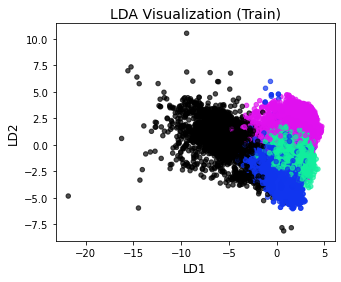

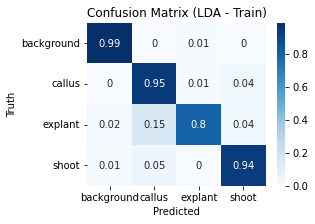

Test

Results shape: (26193, 3)
Labels shape: (26193,)



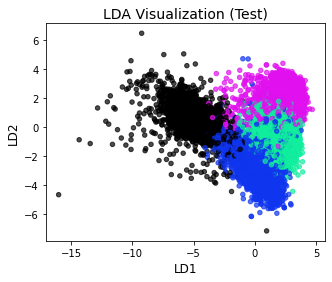

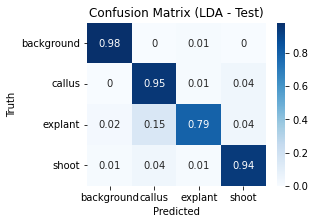

Train

Results shape: (104771,)
Labels shape: (104771,)



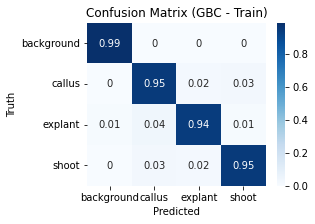

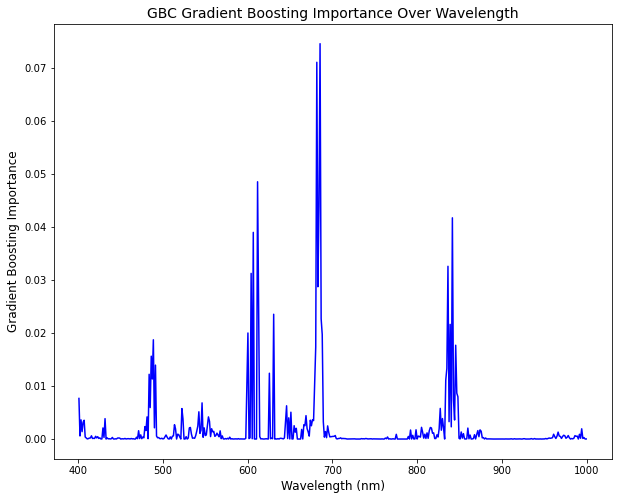

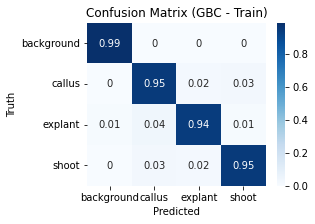

Test

Results shape: (26193,)
Labels shape: (26193,)



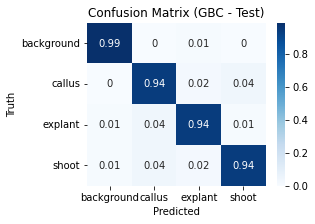

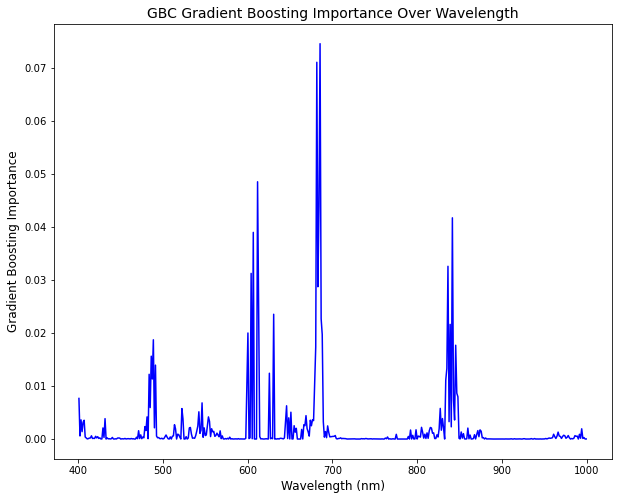

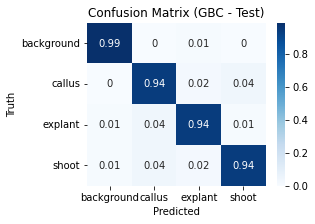

Train

Results shape: (104771,)
Labels shape: (104771,)



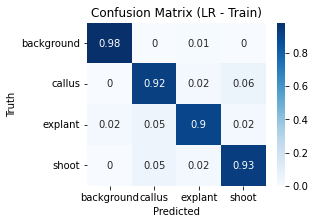

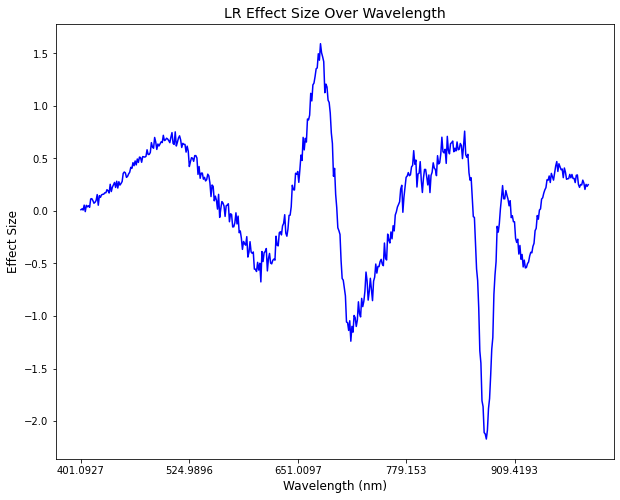

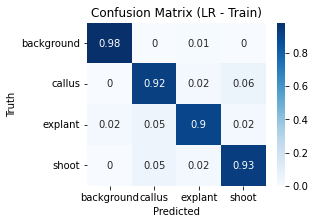

Test

Results shape: (26193,)
Labels shape: (26193,)



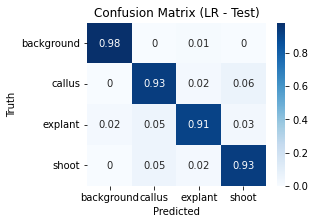

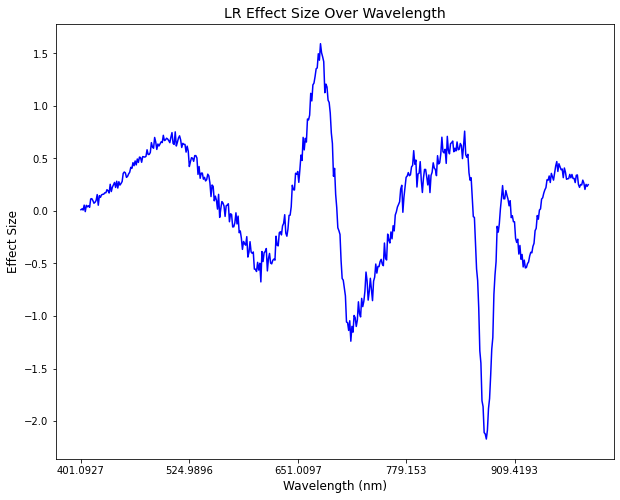

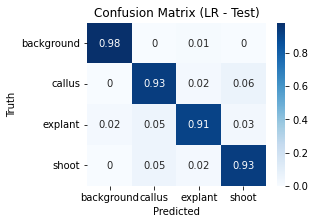

Train

Results shape: (104771,)
Labels shape: (104771,)



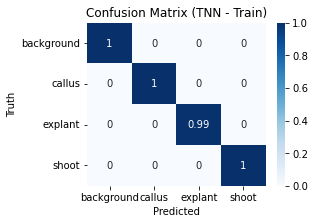

Test

Results shape: (26193,)
Labels shape: (26193,)



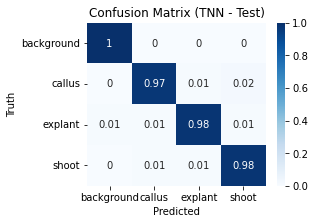

In [30]:
model_types = ["LDA", "GBC", "LR", "TNN"]
#model_types = ["LDA", "TNN"]
data_types = ["Train", "Test"]

school = CubeSchool(training_data, model_types, colors)
school.run()

Let's save out the `CubeSchool` object. One way for us to run inference later (segment previously unseen images) is by loading the `CubeSchool` in and specifying which of the models we wish to deploy.

In [31]:
filename2 = "output/ZTEST4_cubeschool_a10.pkl"                 #change this each model run
pickle.dump(school, open(filename2, 'wb'))

## Evaluation and deployment of `CubeLearner` objects

Here we will consult various plots and metrics to learn about the performance of our models.

### Confusion matrix heatmaps and other model summary plots

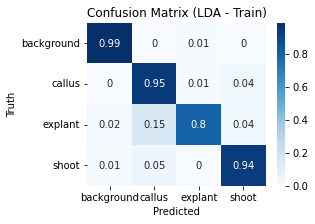

Train

Results shape: (104771, 3)
Labels shape: (104771,)



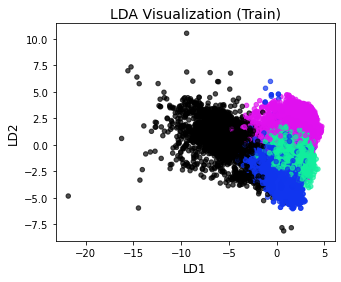

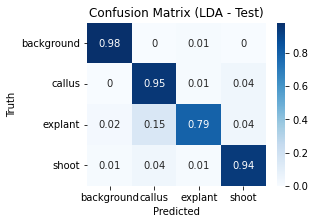

Test

Results shape: (26193, 3)
Labels shape: (26193,)



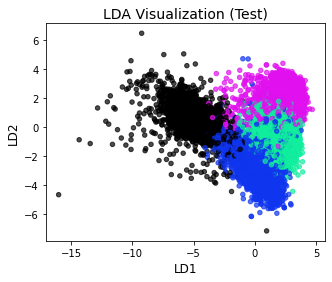

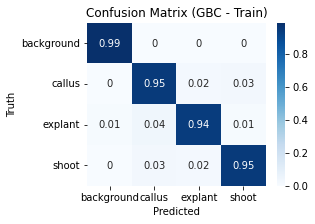

Train

Results shape: (104771,)
Labels shape: (104771,)



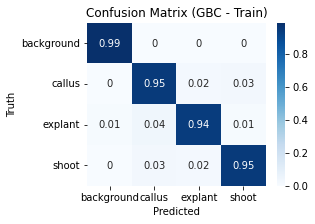

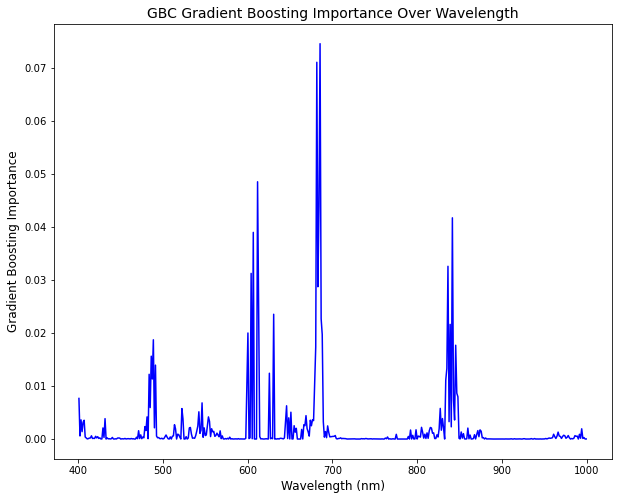

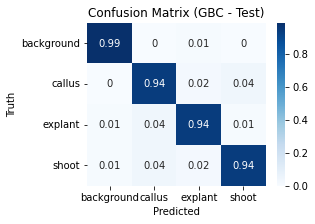

Test

Results shape: (26193,)
Labels shape: (26193,)



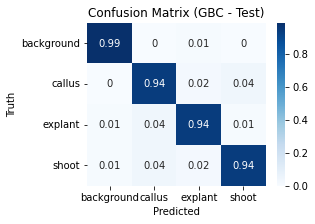

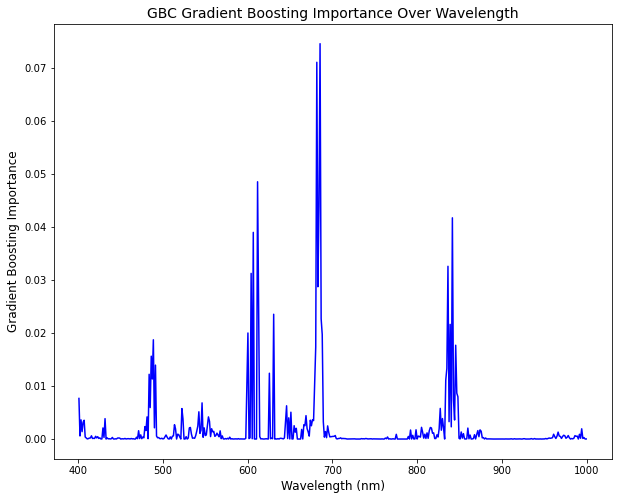

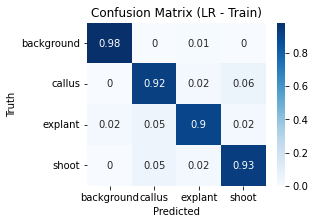

Train

Results shape: (104771,)
Labels shape: (104771,)



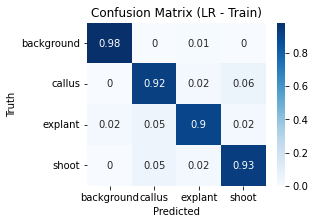

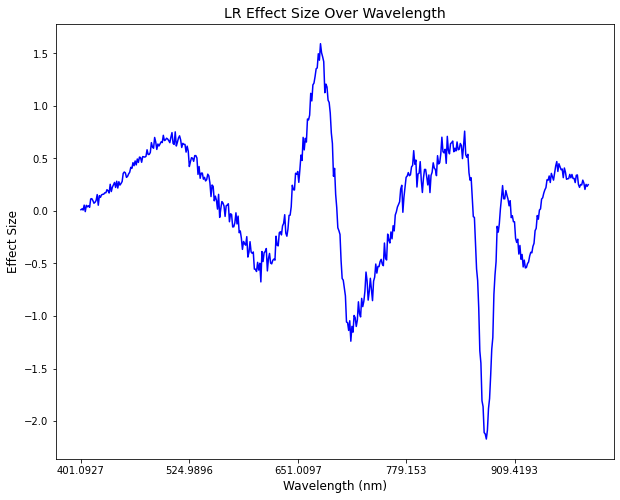

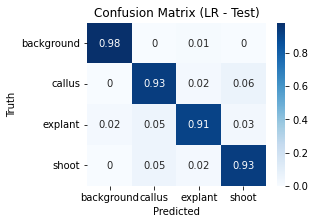

Test

Results shape: (26193,)
Labels shape: (26193,)



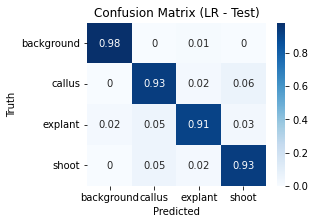

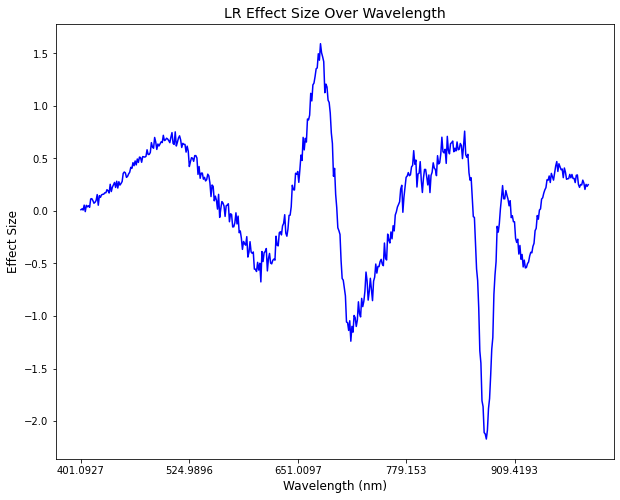

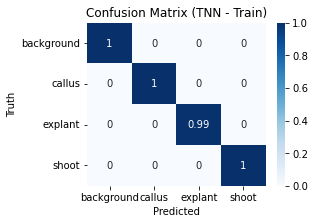

Train

Results shape: (104771,)
Labels shape: (104771,)



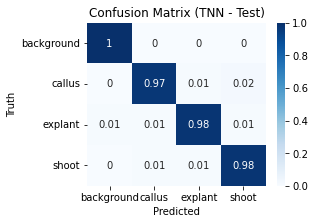

Test

Results shape: (26193,)
Labels shape: (26193,)



In [32]:
school.multi_plot(output_dir = learner_plot_dir)

### IoU table

In [33]:
table = presentable_table(training_data.labels_key_df, school.iou_dict)
filename = "output/" + os.path.basename(os.path.normpath(png_directory.replace('/', '_metrics.csv')))
table.to_csv(filename)

In [34]:
table

Label            background    callus   explant     shoot  mean IoU
Method DataType                                                    
GBC    Train       0.978516  0.896087  0.909790  0.915136  0.924882
       Test        0.970654  0.875516  0.889614  0.890471  0.906564
LDA    Train       0.959187  0.794746  0.775812  0.873121  0.850716
       Test        0.957820  0.793938  0.770178  0.875284  0.849305
LR     Train       0.960881  0.836272  0.863578  0.849616  0.877587
       Test        0.959302  0.843124  0.863326  0.852222  0.879493
TNN    Train       0.996462  0.997751  0.994390  0.997751  0.996588
       Test        0.986397  0.954063  0.957928  0.953793  0.963045

### Inference plots

In [35]:
df = match_files(hypercube_dir)

In [36]:
import torch
import torch.nn as nn
import numpy as np

In [37]:
df.to_csv("02-intermediate_df_matching_rgb_hdr_ZTEST4.csv")                 #change this each model run

In [38]:
# #model_types.remove("PCA")
# generate_falsecolor_images(df = df, 
#                            learner_dict = school.learner_dict,
#                            model_types = model_types,
#                            colors = colors,
#                            output_dir = falsecolor_dir, 
#                            min_wave = 400, 
#                            max_wave = 1000)

In [39]:
import importlib
import sys

In [40]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
from gmodetector_py import Hypercube
from cubeml import CubeLearner
from typing import Union, List

In [41]:
def compare_inferences(df: pd.DataFrame, 
                       num_panels: int = 3,
                       model_types: list = ["LDA", "GBC", "LR", "TNN"],
                       falsecolor_dir: str = "output/falsecolor/",
                       output_dir: str = "output/panel_images/"):
    os.makedirs(output_dir, exist_ok=True)

    for _, row in df.iterrows():
        img_id = row['id']
        png = row['png']

        fig, axs = plt.subplots(len(model_types), 1, figsize=(15, len(model_types)*5))
        if len(model_types) == 1:  # Ensure there's only one axis if there's one model_type
            axs = [axs]

        for ax, model_type in zip(axs, model_types):
            print(f"Processing with {model_type} model")
            false_color_file = os.path.join(falsecolor_dir, f"{img_id}_{model_type}.png")
            img = multi_panel_figure(png, false_color_file, num_panels=num_panels)

            ax.imshow(img)
            ax.axis('off')
            ax.text(-0.02, 0.5, model_type, size=36, ha="right", va="center", rotation='vertical', transform=ax.transAxes)

        plt.subplots_adjust(wspace=0.02, hspace=0.02)
        plt.savefig(os.path.join(output_dir, f"{img_id}_panel.png"), dpi=300)
        plt.close(fig)

In [42]:
def multi_panel_figure(png_file, false_color_file, num_panels=3):
    # Open and rotate PNG file
    png = Image.open(png_file).rotate(270, expand=True)

    # Load false color image
    false_color = Image.open(false_color_file)

    # Ensure both images have same size
    if png.size != false_color.size:
        false_color = false_color.resize(png.size)

    # Create overlay of PNG and false color image
    overlay = Image.blend(png.convert('RGBA'), false_color.convert('RGBA'), alpha=0.5)

    # Merge all images together
    if num_panels == 3:
        images = [png, false_color, overlay]
    elif num_panels == 2:
        images = [false_color, overlay]
    else:
        raise ValueError("num_panels must be either 2 or 3")

    # Ensure all images are the same size
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)

    # Create a blank canvas for the final image
    new_img = Image.new('RGBA', (total_width, max_height))

    # Paste each image into the final image
    for idx, img in enumerate(images):
        new_img.paste(img, (widths[idx] * idx, 0))

    # Return the final image
    return new_img


In [43]:
os.getcwd()

'/media/gmobot/data/NSF_GWAS/notebooks/Broadband/cubeml'

Processing with LDA model
Processing with GBC model
Processing with LR model
Processing with TNN model


FileNotFoundError: [Errno 2] No such file or directory: 'output/falsecolor/HAL1_I5.0_F1.9_H25_180516_0_0_0_TNN.png'

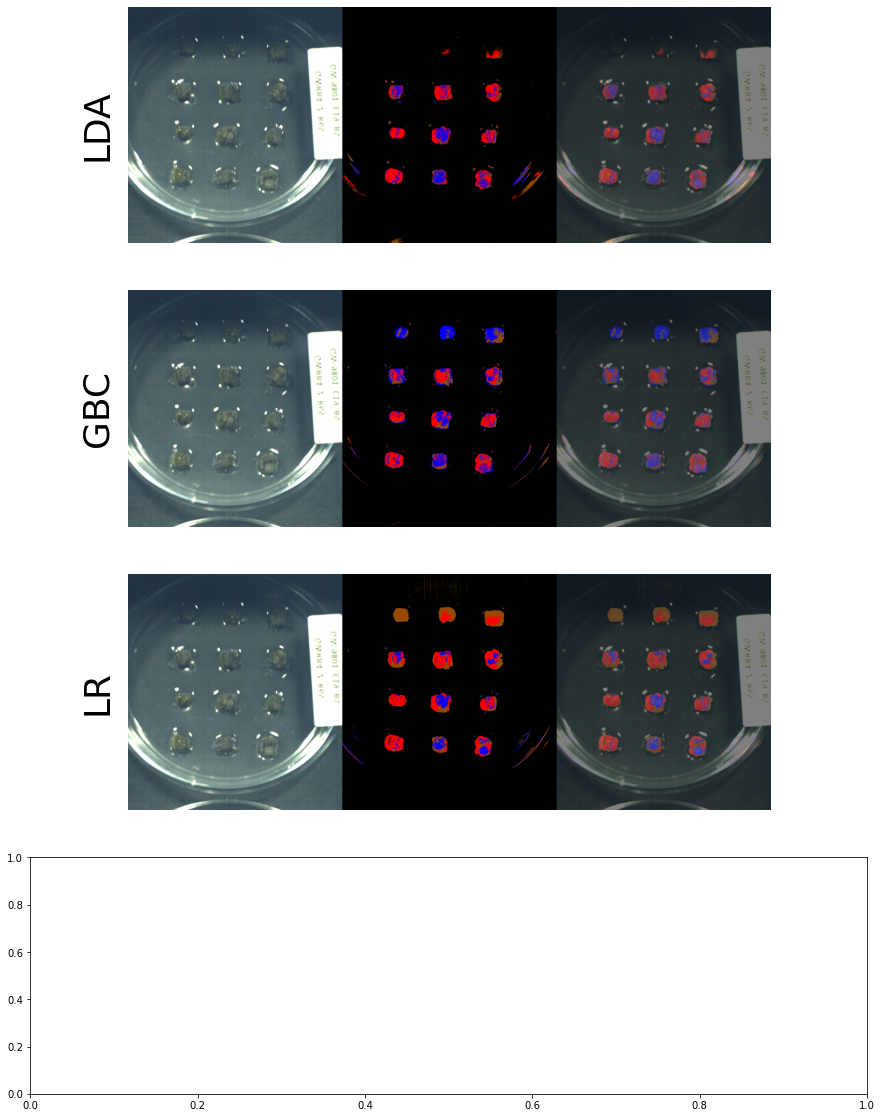

In [44]:
compare_inferences(df = df,
                   model_types = model_types,
                   falsecolor_dir = falsecolor_dir,
                   output_dir = panel_image_dir,
                   num_panels = 3)

## Save for inference

If we are going to run the TNN model on a CPU later, we need to save it out in a special way for compatibility. This is because it was trained on a GPU.

### TNN

In [45]:
def save_cubelearner_state(learner, file_prefix, save_dir="./"):
    model_path = os.path.join(save_dir, f"{file_prefix}_model.pt")
    state_path = os.path.join(save_dir, f"{file_prefix}_state.pkl")

    # Move the model to CPU and save the entire model
    learner.model.to('cpu')
    torch.save(learner.model, model_path)

    # Temporarily remove the model attribute for pickling the rest of the learner
    original_model = learner.model
    learner.model = None

    # Save the rest of the CubeLearner instance
    with open(state_path, 'wb') as f:
        pickle.dump(learner, f)

    # Restore the model attribute
    learner.model = original_model

    return model_path, state_path


In [46]:
learner=school.learner_dict['TNN']

In [47]:
# Check CubeLearner attributes
print("Model Type:", learner.model_type)
print("Device:", learner.device)
print("Number of Classes:", learner.num_classes)

# Check if the model is correctly loaded
if learner.model is not None:
    # Check TransformerNN model attributes
    print("Model d_model:", getattr(learner.model, 'd_model', None))
    print("Model use_embedding:", getattr(learner.model, 'use_embedding', None))
    print("Model num_classes:", getattr(learner, 'num_classes', None))
    print("Positional Encoding (pos_enc):", getattr(learner.model, 'pos_enc', None))
    print("Number of input features (n_input_featurs):", learner.features_train.shape[1])
else:
    print("Model not loaded correctly.")

# Additional check to ensure the model is of the expected type
if isinstance(learner.model, CubeLearner.TransformerNN):
    print("Model is a TransformerNN.")
else:
    print("Model is not a TransformerNN.")

Model Type: TNN
Device: cuda
Number of Classes: 4
Model d_model: 64
Model use_embedding: True
Model num_classes: 4
Positional Encoding (pos_enc): tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
          1.3335e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
          2.6670e-04,  1.0000e+00],
        ...,
        [ 8.6457e-01,  5.0252e-01, -6.6977e-01,  ...,  9.9657e-01,
          6.2102e-02,  9.9807e-01],
        [ 8.8998e-01, -4.5600e-01, -9.9622e-01,  ...,  9.9655e-01,
          6.2235e-02,  9.9806e-01],
        [ 9.7152e-02, -9.9527e-01, -7.8820e-01,  ...,  9.9654e-01,
          6.2368e-02,  9.9805e-01]], device='cuda:0')
Number of input features (n_input_featurs): 469
Model is a TransformerNN.


In [48]:
save_cubelearner_state(learner=school.learner_dict['TNN'],
                       file_prefix="ZTEST4_a10_TNN.pkl",              #change this each model run
                       save_dir="output")

('output/ZTEST4_a10_TNN.pkl_model.pt', 'output/ZTEST4_a10_TNN.pkl_state.pkl')

### Others

We can also save out other `CubeLearner` objects individually, an alternative to saving out the whole `CubeSchool` and later specifying which particular models we want to use.

In [49]:
def save_cubelearners_from_cubeschool(cube_school, file_prefix, save_dir="./"):
    for key, learner in cube_school.learner_dict.items():
        if learner.model_type == 'TNN':
            continue  # Skip TNN models

        # Define the filename for the pkl file
        model_filename = os.path.join(save_dir, f"{file_prefix}_{key}.pkl")

        # Save the entire CubeLearner object to a pkl file
        with open(model_filename, 'wb') as f:
            pickle.dump(learner, f)


In [50]:
# Assuming cube_school is your CubeSchool instance
save_cubelearners_from_cubeschool(school, "ZTEST4_model_a10", "output/")          #change this each model run 
          